In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz


In [5]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /home/caesar/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: /home/caesar/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}

In [6]:
# save images to disk
import os
import torch
import torchvision.transforms as transforms
from PIL import Image

# Create the folder structure
os.makedirs("images/train", exist_ok=True)  # Create train folder if it doesn't exist
os.makedirs("images/test", exist_ok=True)   # Create test folder if it doesn't exist

# Iterate through DataLoaders and save images to respective folders
for loader, folder in zip([train_loader, test_loader], ["train", "test"]):
    for i, (images, _) in enumerate(loader):
        for j, image in enumerate(images):
            # Convert tensor to PIL Image
            image_pil = transforms.ToPILImage()(image)

            # Create a unique filename and save to the corresponding folder
            filename = f"image_{i}_{j}.jpg"
            image_pil.save(os.path.join("images", folder, filename))

            print(f"Saved image {filename} to images/{folder}")  # Track progress


Saved image image_0_0.jpg to images/train
Saved image image_0_1.jpg to images/train
Saved image image_0_2.jpg to images/train
Saved image image_0_3.jpg to images/train
Saved image image_0_4.jpg to images/train
Saved image image_0_5.jpg to images/train
Saved image image_0_6.jpg to images/train
Saved image image_0_7.jpg to images/train
Saved image image_0_8.jpg to images/train
Saved image image_0_9.jpg to images/train
Saved image image_0_10.jpg to images/train
Saved image image_0_11.jpg to images/train
Saved image image_0_12.jpg to images/train
Saved image image_0_13.jpg to images/train
Saved image image_0_14.jpg to images/train
Saved image image_0_15.jpg to images/train
Saved image image_0_16.jpg to images/train
Saved image image_0_17.jpg to images/train
Saved image image_0_18.jpg to images/train
Saved image image_0_19.jpg to images/train
Saved image image_0_20.jpg to images/train
Saved image image_0_21.jpg to images/train
Saved image image_0_22.jpg to images/train
Saved image image_0_2

In [7]:
import glob
from PIL import Image
import numpy as np

# Define the image directory
image_dir = "images/train/"  # Adjust the path to your MNIST images

# Get a list of filenames
image_filenames = glob.glob(f"{image_dir}*.jpg")  # Assuming JPG format

# Create an empty list for PIL images
pil_train_images = []

for filename in image_filenames:
    # Read the image as grayscale
    pil_image = Image.open(filename).convert('L')  # L for grayscale

    # Convert to NumPy array
    image_array = np.array(pil_image)

    # Resize to 224x224
    resized_array = np.expand_dims(image_array, axis=2)  # Add a channel dimension
    resized_array = np.repeat(resized_array, 3, axis=2)  # Replicate to 3 channels
    resized_array = np.resize(resized_array, (224, 224, 3))  # Resize to 224x224

    # Convert back to PIL Image
    resized_pil_image = Image.fromarray(resized_array.astype('uint8'))

    # Append to the list
    pil_train_images.append(resized_pil_image)


In [13]:
import glob
from PIL import Image
import numpy as np

# Define the image directory
image_dir = "images/test/"  # Adjust the path to your MNIST images

# Get a list of filenames
image_filenames = glob.glob(f"{image_dir}*.jpg")  # Assuming JPG format

# Create an empty list for PIL images
pil_test_images = []

for filename in image_filenames:
    # Read the image as grayscale
    pil_image = Image.open(filename).convert('L')  # L for grayscale

    # Convert to NumPy array
    image_array = np.array(pil_image)

    # Resize to 224x224
    resized_array = np.expand_dims(image_array, axis=2)  # Add a channel dimension
    resized_array = np.repeat(resized_array, 3, axis=2)  # Replicate to 3 channels
    resized_array = np.resize(resized_array, (224, 224, 3))  # Resize to 224x224

    # Convert back to PIL Image
    resized_pil_image = Image.fromarray(resized_array.astype('uint8'))

    # Append to the list
    pil_test_images.append(resized_pil_image)


In [14]:
def chunk_list(lst, chunk_size):
    """Splits a list into smaller lists of a given size."""
    return [lst[i : i + chunk_size] for i in range(0, len(lst), chunk_size)]

chunked_train_lists = chunk_list(pil_train_images, 600)  # Split into lists of 600 images

In [15]:
print(len(chunked_train_lists))

8


In [10]:
from img2vec_pytorch import Img2Vec
from PIL import Image

# Create an empty list to store the vectors
vector_train_lists = []

# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=False)

for pil_images in chunked_train_lists:
    # Call the function on the current list of images
    vectors = img2vec.get_vec(pil_images)

    # Append the resulting vectors to the vector_lists list
    vector_train_lists.append(vectors)

from itertools import chain
vectors_train = list(chain.from_iterable(vector_train_lists))

/home/caesar/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/caesar/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=False)
vectors_test = img2vec.get_vec(pil_test_images)

In [17]:
print(len(vectors_train[0]))
print(len(vectors_test[0]))

512
512


In [18]:
x_train = np.array(vectors_train)
x_test = np.array(vectors_test)

In [19]:
print(x_train.shape)
print(x_test.shape)

(4708, 512)
(624, 512)


In [20]:
# Create an empty NumPy array to store the targets
train_targets = np.empty(0, dtype=float)  # Adjust dtype if necessary

# Iterate through the DataLoader and concatenate targets
for batch in train_loader:
    _, targets = batch  # Assuming targets are in the second element of the batch
    targets = targets.numpy().flatten()  # Convert batch of targets to NumPy and flatten it
    train_targets = np.concatenate((train_targets, targets))  # Concatenate directly

In [21]:
# Create an empty NumPy array to store the targets
test_targets = np.empty(0, dtype=float)  # Adjust dtype if necessary

# Iterate through the DataLoader and concatenate targets
for batch in test_loader:
    _, targets = batch  # Assuming targets are in the second element of the batch
    targets = targets.numpy().flatten()  # Convert batch of targets to NumPy and flatten it
    test_targets = np.concatenate((test_targets, targets))  # Concatenate directly

In [22]:
print(train_targets.shape)
print(test_targets.shape)

(4708,)
(624,)


In [23]:
y_train = train_targets
y_test = test_targets

In [24]:
# Get the list of filenames
filenames = sorted(os.listdir('images/train'))

# Open the output file
with open('train.arff', 'w') as f:
    # Write the header
    f.write('@relation normal_vs_pneumonia\n')
    f.write('@attribute filename string\n')
    f.write('@attribute class {pneumonia,normal}\n')
    f.write('@data\n')

    # Write the data
    for filename, label in zip(filenames, y_train):
        class_name = 'pneumonia' if label == 1 else 'normal'
        f.write(f'{filename},{class_name}\n')

In [26]:
# Get the list of filenames
filenames = sorted(os.listdir('images/test'))

# Open the output file
with open('test.arff', 'w') as f:
    # Write the header
    f.write('@relation normal_vs_pneumonia\n')
    f.write('@attribute filename string\n')
    f.write('@attribute class {pneumonia,normal}\n')
    f.write('@data\n')

    # Write the data
    for filename, label in zip(filenames, y_train):
        class_name = 'pneumonia' if label == 1 else 'normal'
        f.write(f'{filename},{class_name}\n')

In [27]:
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [28]:
# Load the datasets
train = pd.read_csv('train-filters.csv')
test = pd.read_csv('test-filters.csv')

# Separate features and labels
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

In [39]:
# Define the SVM classifier
clf = svm.SVC(kernel='rbf', class_weight='balanced')

# Train the classifier
clf.fit(X_train, y_train)

SVC(class_weight='balanced')

In [40]:
# Predict the labels of the test set
y_pred = clf.predict(X_test)

In [41]:
# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      normal       0.30      0.45      0.36       165
   pneumonia       0.76      0.63      0.69       459

    accuracy                           0.58       624
   macro avg       0.53      0.54      0.53       624
weighted avg       0.64      0.58      0.60       624



In [42]:
y_test = y_test.ravel()
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.5817307692307693


              precision    recall  f1-score   support

      normal       0.30      0.45      0.36       165
   pneumonia       0.76      0.63      0.69       459

    accuracy                           0.58       624
   macro avg       0.53      0.54      0.53       624
weighted avg       0.64      0.58      0.60       624



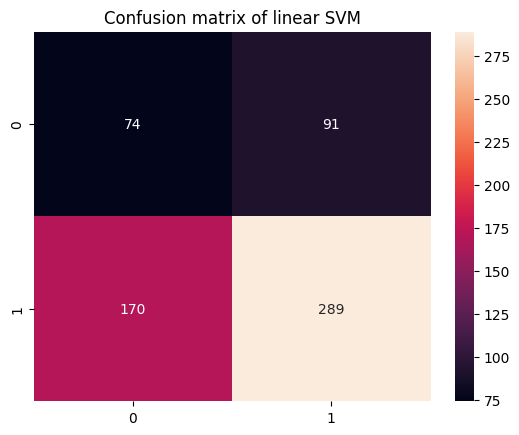

In [43]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

print(classification_report(y_test,y_pred))

In [ ]:
# let's try merging both datasets in one and check SVM on it

In [44]:
import pandas as pd

# Load the two CSV files
df1 = pd.read_csv('train-filters.csv')
df2 = pd.read_csv('test-filters.csv')

# Concatenate the dataframes
merged_df = pd.concat([df1, df2])

# Save the merged dataframe to a new CSV file
merged_df.to_csv('all-dataset.csv', index=False)

In [45]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load the CSV file
df = pd.read_csv('all-dataset.csv')

# Separate the features and the target
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]  # Target

# Encode the target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Create a SVM Classifier
clf = svm.SVC(kernel='rbf')  # Linear Kernel

# Train the model using the training sets
clf.fit(X_train, y_train)

SVC()

In [52]:
# Predict the response for test dataset
y_pred = clf.predict(X_test)

In [53]:
# Model Accuracy
print("Accuracy:", clf.score(X_test, y_test))

Accuracy: 0.7441424554826617


In [54]:
# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       273
   pneumonia       0.74      1.00      0.85       794

    accuracy                           0.74      1067
   macro avg       0.37      0.50      0.43      1067
weighted avg       0.55      0.74      0.63      1067



/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       273
           1       0.74      1.00      0.85       794

    accuracy                           0.74      1067
   macro avg       0.37      0.50      0.43      1067
weighted avg       0.55      0.74      0.63      1067



/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


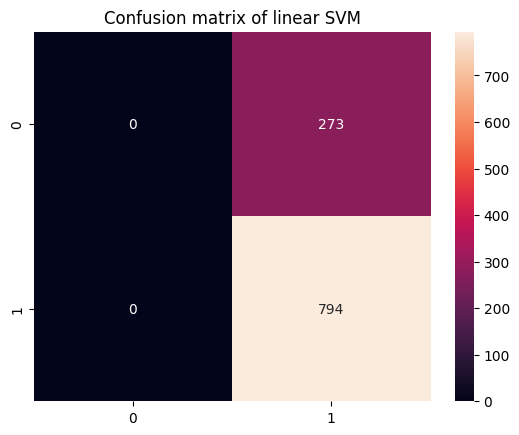

In [55]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

print(classification_report(y_test,y_pred))